# 模型结构：
- Data
- Patches Embeddings
    - CLS Token
    - Position Embedding
- Transformer
    - Attention
    - Residuals
    - MLP
    - TransformerEncoder
  
- Head
- ViT

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
from torchinfo import summary # torchifo库用于直观查看模型中各个层的输出维度以及参数量，是对模型结构信息的总结库



import matplotlib.pyplot as plt
from PIL import Image
from einops import rearrange, reduce, repeat  # 专注于简化和规范化深度学习中张量操作的库，对多维数据的操作变得直观和易于理解
                                               # rearrange：维度重排，reduce：数据聚合如求和最大值等，repeat：元素重复，增加维度
from einops.layers.torch import Rearrange, Reduce

# ------------------------------------1、数据预处理-------------------------------------------------

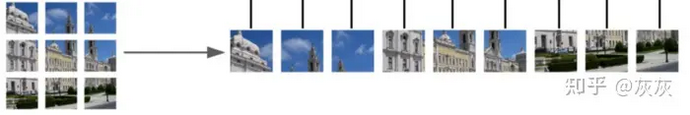

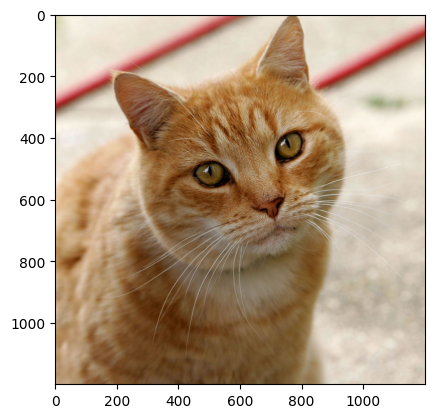

In [2]:
"""先导入一张图片"""
img = Image.open('data/cat.jpg')
fig = plt.figure()
plt.imshow(img)

In [3]:
"""将图片调整大小并转换成tensor"""
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # 添加一个批量维度
x.shape

torch.Size([1, 3, 224, 224])

# ------------------------------------2、Patches Embeddings------------------------------------

- 先将向量分切后展平，然后添加clstoken和位置编码
- cls：适用于像nlp一样记录全局信息的
- 位置编码：用于记录位置信息的，也和nlp一样

In [22]:
"""将图像分解为多个切片并将其展平为embedding向量"""
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int = 3, patch_size:int = 16, embed_size:int = 768, img_size=224):
        self.patch_size = patch_size
        super().__init__()
        
        # 定义展平和线性映射embed操作
        self.projection = nn.Sequential(
            # 用卷积层代替线性层->性能提升
            nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),# 使用卷积层来分割
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        
        # 添加clstoken操作
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        
        # 添加位置编码操作
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, embed_size))
        
    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # 将cls加到张量上
        x = torch.cat([cls_tokens, x], dim=1)
        # 加上位置编码
        x += self.positions
        return x

# 分割后的向量从([1, 3, 224, 224])变为([1, 196, 768])
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

# ------------------------------------3、Transformer------------------------------------

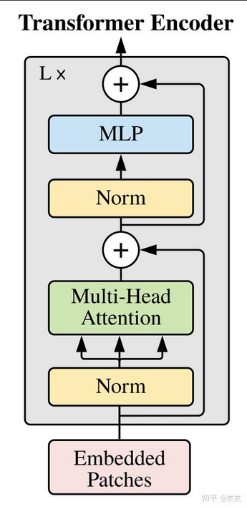

``` python 
`out = torch.einsum('bhal, bhlv -> bhav', att, values)` 这一行代码使用了 PyTorch 中的 `torch.einsum` 函数，它基于 Einstein 求和记号（Einstein summation convention）进行高效的张量操作。在多头注意力机制中，此操作用于计算加权后的值向量（values）。

参数解释：
- `att`：形状为 `(batch_size, num_heads, attention_output_length, key_length)` 的张量，表示每个查询位置对所有键位置的注意力权重。
- `values`：形状为 `(batch_size, num_heads, key_length, emb_size_per_head)` 的张量，其中包含了每个键对应的值。

Einstein 求和记号 `'bhal, bhlv -> bhav'` 描述了如何通过索引对这两个张量进行运算：

- `'bhal'` 表示 `att` 张量的四个维度：`batch`（批处理样本数）、`head`（注意力头的数量）、`attention_output_length`（输出序列长度，即每个查询对应的位置数量）、以及 `key_length`（键序列长度，与 `att` 中的第四维相对应）。
- `'bhlv'` 表示 `values` 张量的四个维度：同样包括 `batch`、`head` 和 `key_length`，最后一个维度是 `emb_size_per_head`（每个注意力头对应的嵌入尺寸）。
- `'bhav'` 是输出张量的维度标签，它合并了前三个维度 (`batch`, `head`, `attention_output_length`) 以及 `values` 的最后一个维度 `emb_size_per_head`。

运算过程：
这个 einsum 表达式执行的是按元素乘法和按特定维度的求和。具体而言，对于每个批次、每个注意力头、以及每个查询输出位置，会将注意力权重矩阵 `att` 与相应位置的值矩阵 `values` 进行点积，并沿 `key_length` 维度（第四个维度）进行求和。最终得到的 `out` 张量形状为 `(batch_size, num_heads, attention_output_length, emb_size_per_head)`，它是各个查询位置经过加权求和后生成的新值向量集合。

```

In [5]:
"""先定义注意力"""
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0.):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        
        # 将计算q, k, v融合到一个矩阵中
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x, mask=None):
        # 分割num_heads中的q, k ,v 
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h = self.num_heads, qkv=3)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # 点积计算qkv
        energy = torch.einsum('bhqd, bhkd -> bhqk', q, k) # batch, num_heads, query_len, key_len
        
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            engery.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        
        # 在第三个轴维度上求和
        out = torch.einsum('bhal, bhlv -> bhav', att, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        
        return out

In [6]:
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

In [7]:
"""定义残差（起始这一步没必要单独列出来，直接在注意力里操作就行）"""
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [8]:
"""定义MLP层"""
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, drop_p=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)
        )

In [9]:
"""组合成最终的transform模块"""
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size=768, drop_p=0., forward_expansion=4, forward_drop_p=0., **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p))),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)))
        )

In [10]:
"""搭建想要的transform层数"""
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [11]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

# ------------------------------------4、Heads------------------------------------

- 最后一层给出正常分类输出项

In [12]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=768, n_classes=1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

# ------------------------------------5、完成的VIT模型------------------------------------

In [13]:
class ViT(nn.Sequential):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224, depth=12, n_classes=1000, **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size), # 1.分块图像和转成向量，输出[batch, 块数，每块对应的embdding]
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),     # 2.进入多头注意力中，输出[batch，块数，每块对应的embdding]
            ClassificationHead(emb_size, n_classes)                     # 3.进入分类块，输出分类结果[batch， n_classes]
        )   

In [23]:
"""查看整个模型的参数量信息"""
summary(ViT(), (1,3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [1, 1000]                 --
├─PatchEmbedding: 1-1                              [1, 197, 768]             152,064
│    └─Sequential: 2-1                             [1, 196, 768]             --
│    │    └─Conv2d: 3-1                            [1, 768, 14, 14]          590,592
│    │    └─Rearrange: 3-2                         [1, 196, 768]             --
├─TransformerEncoder: 1-2                          [1, 197, 768]             --
│    └─TransformerEncoderBlock: 2-2                [1, 197, 768]             --
│    │    └─ResidualAdd: 3-3                       [1, 197, 768]             2,363,904
│    │    └─ResidualAdd: 3-4                       [1, 197, 768]             4,723,968
│    └─TransformerEncoderBlock: 2-3                [1, 197, 768]             --
│    │    └─ResidualAdd: 3-5                       [1, 197, 768]             2,363,904
│   